In [1]:
%pip install --upgrade jupyter ipywidgets
%jupyter nbextension enable --py widgetsnbextension

Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%jupyter` not found.


In [5]:
import os
import sys
import json
from collections import Counter

import boto3
import clickhouse_connect
import criu
import matplotlib.pyplot as plt
import pandas as pd

# Directories
COLLECT_INFO_DIR = "result/1-collect-info"
CPUINFO_ALL_DIR = "result/0-cpuinfo-all"

# Caches to avoid re-reading and re-parsing files
CPUINFO_CACHE = {}
ISASET_CACHE = {}


In [6]:
def criu_check(src_instance: str, all_instances: list):
    """
    Checks migration compatibility using the CRIU method.
    """
    src_cpuinfo_path = os.path.join(COLLECT_INFO_DIR, src_instance, "cpuinfo.img")
    
    if not os.path.exists(src_cpuinfo_path):
        print(f"Error: Source cpuinfo.img not found at {src_cpuinfo_path}", file=sys.stderr)
        return []

    if src_instance in CPUINFO_CACHE:
        src_info = CPUINFO_CACHE[src_instance]
    else:
        src_info = criu.parse_cpuinfo(src_cpuinfo_path)
        if not src_info:
            return []
        CPUINFO_CACHE[src_instance] = src_info

    compatible_instances = []
    for dst_instance in all_instances:
        if dst_instance == src_instance:
            continue

        if dst_instance in CPUINFO_CACHE:
            dst_info = CPUINFO_CACHE[dst_instance]
        else:
            dst_cpuinfo_path = os.path.join(CPUINFO_ALL_DIR, dst_instance, "cpuinfo.img")
            if not os.path.exists(dst_cpuinfo_path):
                continue

            dst_info = criu.parse_cpuinfo(dst_cpuinfo_path)
            if not dst_info:
                continue
            CPUINFO_CACHE[dst_instance] = dst_info
        
        errors = criu.check_migration(src_info, dst_info)
        if not errors:
            compatible_instances.append(dst_instance)
    
    return sorted(compatible_instances)


def pygration_check(src_instance: str, workload: str, all_instances: list):
    """
    Checks migration compatibility using the Pygration method.
    """
    bytecode_path = os.path.join(COLLECT_INFO_DIR, src_instance, f"{workload}.bytecode.csv")
    
    if not os.path.exists(bytecode_path):
        print(f"Error: Workload bytecode file not found at {bytecode_path}", file=sys.stderr)
        return []

    try:
        df_bytecode = pd.read_csv(bytecode_path)
        required_isa_sets = set(df_bytecode[df_bytecode['ISA_SET'] != 'Error']['ISA_SET'].unique())
    except Exception as e:
        print(f"Error reading or processing {bytecode_path}: {e}", file=sys.stderr)
        return []

    # Get source instance's ISA set for normalization
    if src_instance in ISASET_CACHE:
        src_supported_isa_sets = ISASET_CACHE[src_instance]
    else:
        src_isaset_path = os.path.join(CPUINFO_ALL_DIR, src_instance, "isaset.csv")
        if not os.path.exists(src_isaset_path):
            print(f"Warning: ISA set for source instance {src_instance} not found, cannot normalize.", file=sys.stderr)
            return []
        try:
            df_src_isaset = pd.read_csv(src_isaset_path)
            src_supported_isa_sets = set(df_src_isaset.columns[df_src_isaset.iloc[0] == 1])
            ISASET_CACHE[src_instance] = src_supported_isa_sets
        except Exception as e:
            print(f"Warning: Could not process {src_isaset_path}: {e}", file=sys.stderr)
            return []
            
    normalized_isa_sets = required_isa_sets.intersection(src_supported_isa_sets)

    compatible_instances = []
    for dst_instance in all_instances:
        if dst_instance == src_instance:
            continue

        if dst_instance in ISASET_CACHE:
            supported_isa_sets = ISASET_CACHE[dst_instance]
        else:
            isaset_path = os.path.join(CPUINFO_ALL_DIR, dst_instance, "isaset.csv")
            if not os.path.exists(isaset_path):
                continue
            
            try:
                df_isaset = pd.read_csv(isaset_path)
                supported_isa_sets = set(df_isaset.columns[df_isaset.iloc[0] == 1])
                ISASET_CACHE[dst_instance] = supported_isa_sets
            except Exception as e:
                # print(f"Warning: Could not process {isaset_path}: {e}", file=sys.stderr)
                continue
        
        if normalized_isa_sets.issubset(supported_isa_sets):
            compatible_instances.append(dst_instance)

    return sorted(compatible_instances)


def pygration_full_scan_check(src_instance: str, workload: str, all_instances: list):
    """
    Checks migration compatibility using the Pygration method (full scan).
    """
    full_scan_path = os.path.join(COLLECT_INFO_DIR, src_instance, f"{workload}.text_segment_full_scan.csv")
    
    if not os.path.exists(full_scan_path):
        # This is not an error, some workloads might not have full_scan files.
        return []

    try:
        df_full_scan = pd.read_csv(full_scan_path)
        required_isa_sets = set(df_full_scan[df_full_scan['ISA_SET'] != 'Error']['ISA_SET'].unique())
    except Exception as e:
        print(f"Error reading or processing {full_scan_path}: {e}", file=sys.stderr)
        return []

    # Get source instance's ISA set for normalization
    if src_instance in ISASET_CACHE:
        src_supported_isa_sets = ISASET_CACHE[src_instance]
    else:
        src_isaset_path = os.path.join(CPUINFO_ALL_DIR, src_instance, "isaset.csv")
        if not os.path.exists(src_isaset_path):
            print(f"Warning: ISA set for source instance {src_instance} not found, cannot normalize.", file=sys.stderr)
            return []
        try:
            df_src_isaset = pd.read_csv(src_isaset_path)
            src_supported_isa_sets = set(df_src_isaset.columns[df_src_isaset.iloc[0] == 1])
            ISASET_CACHE[src_instance] = src_supported_isa_sets
        except Exception as e:
            print(f"Warning: Could not process {src_isaset_path}: {e}", file=sys.stderr)
            return []
            
    normalized_isa_sets = required_isa_sets.intersection(src_supported_isa_sets)

    compatible_instances = []
    for dst_instance in all_instances:
        if dst_instance == src_instance:
            continue

        if dst_instance in ISASET_CACHE:
            supported_isa_sets = ISASET_CACHE[dst_instance]
        else:
            isaset_path = os.path.join(CPUINFO_ALL_DIR, dst_instance, "isaset.csv")
            if not os.path.exists(isaset_path):
                continue
            
            try:
                df_isaset = pd.read_csv(isaset_path)
                supported_isa_sets = set(df_isaset.columns[df_isaset.iloc[0] == 1])
                ISASET_CACHE[dst_instance] = supported_isa_sets
            except Exception as e:
                # print(f"Warning: Could not process {isaset_path}: {e}", file=sys.stderr)
                continue
        
        if normalized_isa_sets.issubset(supported_isa_sets):
            compatible_instances.append(dst_instance)

    return sorted(compatible_instances)


In [7]:
migration_data = {}

# Add instance types to this list to exclude them from the analysis
exclude_instances = [
    # "c5a.large",
    # "c6a.xlarge",
]

try:
    all_instances = sorted([d for d in os.listdir(CPUINFO_ALL_DIR) if os.path.isdir(os.path.join(CPUINFO_ALL_DIR, d))])
    print(f"Found {len(all_instances)} instance types.")
except FileNotFoundError:
    print(f"Error: Directory not found: {CPUINFO_ALL_DIR}", file=sys.stderr)
    all_instances = []

src_instances_all = sorted([d for d in os.listdir(COLLECT_INFO_DIR) if os.path.isdir(os.path.join(COLLECT_INFO_DIR, d))])
src_instances = [inst for inst in src_instances_all if inst not in exclude_instances]
print(f"Found {len(src_instances_all)} source instances, processing {len(src_instances)} after excluding {len(exclude_instances)} instances.")

for src_instance in src_instances:
    if src_instance not in all_instances:
        print(f"Error: Instance type '{src_instance}' not found in {CPUINFO_ALL_DIR}", file=sys.stderr)
        continue

    print(f"Processing: {src_instance}")
    
    migration_data[src_instance] = {}

    # CRIU Check
    criu_compatible = criu_check(src_instance, all_instances)
    migration_data[src_instance]['criu'] = criu_compatible

    # Pygration Check for all workloads
    migration_data[src_instance]['pygration'] = {}
    migration_data[src_instance]['pygration_full_scan'] = {}
    src_collect_path = os.path.join(COLLECT_INFO_DIR, src_instance)
    if os.path.isdir(src_collect_path):
        files = os.listdir(src_collect_path)
        
        # Bytecode
        workloads_to_check = sorted([
            f.replace(".bytecode.csv", "")
            for f in files
            if f.endswith(".bytecode.csv")
        ])
        for workload in workloads_to_check:
            pygration_compatible = pygration_check(src_instance, workload, all_instances)
            migration_data[src_instance]['pygration'][workload] = pygration_compatible

        # Full scan
        workloads_to_check_full_scan = sorted([
            f.replace(".text_segment_full_scan.csv", "")
            for f in files
            if f.endswith(".text_segment_full_scan.csv")
        ])
        for workload in workloads_to_check_full_scan:
            pygration_compatible = pygration_full_scan_check(src_instance, workload, all_instances)
            migration_data[src_instance]['pygration_full_scan'][workload] = pygration_compatible

print("Data collection complete.")
print(f"Processed {len(migration_data)} source instances.")


Found 521 instance types.
Found 22 source instances, processing 22 after excluding 0 instances.
Processing: c4.8xlarge
Processing: c4.xlarge
Processing: c5.9xlarge
Processing: c5a.24xlarge
Processing: c5a.large
Processing: c6a.24xlarge
Processing: c6a.xlarge
Processing: c6i.16xlarge
Processing: c6i.large
Processing: c7i.4xlarge
Processing: c7i.xlarge
Processing: h1.8xlarge
Processing: i3.xlarge
Processing: m4.16xlarge
Processing: m5n.large
Processing: m5zn.6xlarge
Processing: m7a.medium
Processing: r4.8xlarge
Processing: r4.large
Processing: r8i.large
Processing: t3.medium
Processing: t3a.medium
Data collection complete.
Processed 22 source instances.


In [8]:
print(migration_data.keys())
print(migration_data["c4.8xlarge"]["pygration_full_scan"])

dict_keys(['c4.8xlarge', 'c4.xlarge', 'c5.9xlarge', 'c5a.24xlarge', 'c5a.large', 'c6a.24xlarge', 'c6a.xlarge', 'c6i.16xlarge', 'c6i.large', 'c7i.4xlarge', 'c7i.xlarge', 'h1.8xlarge', 'i3.xlarge', 'm4.16xlarge', 'm5n.large', 'm5zn.6xlarge', 'm7a.medium', 'r4.8xlarge', 'r4.large', 'r8i.large', 't3.medium', 't3a.medium'])
{'beautifulsoup4': ['c4.2xlarge', 'c4.4xlarge', 'c4.xlarge', 'c5.12xlarge', 'c5.18xlarge', 'c5.24xlarge', 'c5.2xlarge', 'c5.4xlarge', 'c5.9xlarge', 'c5.large', 'c5.xlarge', 'c5a.12xlarge', 'c5a.16xlarge', 'c5a.24xlarge', 'c5a.2xlarge', 'c5a.4xlarge', 'c5a.8xlarge', 'c5a.large', 'c5a.xlarge', 'c5ad.12xlarge', 'c5ad.16xlarge', 'c5ad.24xlarge', 'c5ad.2xlarge', 'c5ad.4xlarge', 'c5ad.8xlarge', 'c5ad.large', 'c5ad.xlarge', 'c5d.12xlarge', 'c5d.18xlarge', 'c5d.24xlarge', 'c5d.2xlarge', 'c5d.4xlarge', 'c5d.9xlarge', 'c5d.large', 'c5d.xlarge', 'c5n.18xlarge', 'c5n.2xlarge', 'c5n.4xlarge', 'c5n.9xlarge', 'c5n.large', 'c5n.xlarge', 'c6a.12xlarge', 'c6a.16xlarge', 'c6a.24xlarge', 'c

In [9]:
def get_all_instance_specs():
    """Fetches vCPU and memory for all EC2 instance types."""
    print("Fetching all EC2 instance specifications from AWS...")
    ec2 = boto3.client('ec2', region_name='us-west-2')
    paginator = ec2.get_paginator('describe_instance_types')
    instance_specs = {}
    try:
        for page in paginator.paginate(Filters=[{'Name': 'instance-type', 'Values': ['*']}]):
            for info in page['InstanceTypes']:
                instance_type = info['InstanceType']
                vcpus = info.get('VCpuInfo', {}).get('DefaultVCpus')
                memory = info.get('MemoryInfo', {}).get('SizeInMiB')
                size = instance_type.split('.')[1]
                if vcpus and memory:
                    instance_specs[instance_type] = {'vcpus': vcpus, 'memory': memory, 'size': size}
    except Exception as e:
        print(f"Could not fetch instance specs from AWS: {e}")
        print("Please ensure your AWS credentials and permissions are set up correctly.")
    print(f"Successfully fetched specifications for {len(instance_specs)} instance types.")
    return instance_specs

ALL_INSTANCE_SPECS = get_all_instance_specs()

Fetching all EC2 instance specifications from AWS...
Successfully fetched specifications for 945 instance types.


In [10]:
cache = {}

In [11]:
# This function can be used to filter instances by vCPU/memory if needed
def filter_by_specs(unfiltered_list):
    # return unfiltered_list
    return [
        inst for inst in unfiltered_list 

        # cpu, memory 등 모두 동일
        # if inst in ALL_INSTANCE_SPECS and ALL_INSTANCE_SPECS[inst]['vcpus'] == source_specs['vcpus'] and ALL_INSTANCE_SPECS[inst]['memory'] == source_specs['memory']

        # cpu, memory가 더 크면 허용
        if inst in ALL_INSTANCE_SPECS and ALL_INSTANCE_SPECS[inst]['vcpus'] >= source_specs['vcpus'] and ALL_INSTANCE_SPECS[inst]['memory'] >= source_specs['memory']

        # 사이즈 (large, xlarge)가 같으면 허용
        # if inst in ALL_INSTANCE_SPECS and ALL_INSTANCE_SPECS[inst]['size'] == source_specs['size']

        # cpu, memory중 하나만 더 크고 나머지 하나는 같음
        # if inst in ALL_INSTANCE_SPECS and (ALL_INSTANCE_SPECS[inst]['vcpus'] >= source_specs['vcpus'] and ALL_INSTANCE_SPECS[inst]['memory'] == source_specs['memory']) or (ALL_INSTANCE_SPECS[inst]['vcpus'] == source_specs['vcpus'] and ALL_INSTANCE_SPECS[inst]['memory'] >= source_specs['memory'])
    ]

In [12]:
# 인스턴스 관계없이 그냥 max, min
client = clickhouse_connect.get_client(
    host="10.192.0.102",
    port=8123,
    username="clickhouse",
    password="74p6dcbSS11XmQEuqIEEENMb0yjt3JLH",
)

# Fetched metrics table
METRICS = {
    'IF': 'max("IF")',
    'Savings': 'max("Savings")',
    'SPS': 'max("SPS")',
    'SpotPrice': 'minIf("SpotPrice", "SpotPrice" >= 0)',
    'T3': 'max("T3")'
}
METRICS_TABLE = list(METRICS.keys())

def get_data(instance_types: list, order_by=None):
    """
    For each timestamp, finds the best instance based on the sorting criteria,
    and returns all its metrics from the METRICS_TABLE.
    
    :param instance_types: A list of instance types to consider.
    :param order_by: A list of tuples, e.g., [("SpotPrice", "ASC"), ("IF", "DESC")]
    """
        
    if not instance_types:
        return pd.DataFrame()

    # Constructing the columns to select, ensuring proper quoting for all
    selected_columns = ", ".join([f'{METRICS[col]} AS "{col}"' for col in METRICS_TABLE])

    query = f"""
    SELECT Time, {selected_columns}
    FROM data
    WHERE Region = 'us-west-2'
          AND Time >= '2025-05-08 00:00:00'
          AND Time < '2025-05-09 00:00:00'
          AND InstanceType IN %(instance_types)s
    GROUP BY Time
    ORDER BY Time
    """

    # Use a tuple of instance_types and query for cache key
    it_json = json.dumps(sorted(list(instance_types)))
    cache_key = (it_json, query)

    if cache_key in cache:
        return cache[cache_key]

    try:
        result_df = client.query_df(query, parameters={'instance_types': instance_types})
        cache[cache_key] = result_df
        return result_df
    except Exception as e:
        print(f"An error occurred during query: {e}")
        return pd.DataFrame()

# Initialize results dictionaries
criu_results = {metric: [] for metric in METRICS_TABLE}
pygration_results = {metric: [] for metric in METRICS_TABLE}
pygration_full_scan_results = {metric: [] for metric in METRICS_TABLE}
not_found_criu = []
not_found_pygration = []
not_found_pygration_full_scan = []

for instance_type, data in migration_data.items():
    if instance_type not in ALL_INSTANCE_SPECS:
        continue
    
    source_specs = ALL_INSTANCE_SPECS[instance_type]

    criu_instances = filter_by_specs(data.get('criu', []))

    pygration_instance_sets = []
    pygration_workloads = data.get('pygration', {})
    for workload, instances in pygration_workloads.items():
        if "dask_matmul" in workload:
            continue
        pygration_instance_sets.append(filter_by_specs(instances))
        
    pygration_full_scan_instance_sets = []
    pygration_full_scan_workloads = data.get('pygration_full_scan', {})
    for workload, instances in pygration_full_scan_workloads.items():
        if "dask_matmul" in workload:
            continue
        pygration_full_scan_instance_sets.append(filter_by_specs(instances))

    print(f"Processing {instance_type}...")

    # --- CRIU ---
    criu_df = get_data(criu_instances)
    if not criu_df.empty:
        for metric in METRICS_TABLE:
            criu_results[metric].extend(criu_df[metric].tolist())
    if criu_df.empty and criu_instances:
        not_found_criu.append(instance_type)


    # --- Pygration (Bytecode) ---
    pygration_found_data = False
    for instance_set in pygration_instance_sets:
        if not instance_set: continue
        pygration_df = get_data(instance_set)
        if not pygration_df.empty:
            pygration_found_data = True
            for metric in METRICS_TABLE:
                pygration_results[metric].extend(pygration_df[metric].tolist())
    if not pygration_found_data and any(pygration_instance_sets):
        not_found_pygration.append(instance_type)
        
    # --- Pygration (Full Scan) ---
    pygration_full_scan_found_data = False
    for instance_set in pygration_full_scan_instance_sets:
        if not instance_set: continue
        pygration_df = get_data(instance_set)
        if not pygration_df.empty:
            pygration_full_scan_found_data = True
            for metric in METRICS_TABLE:
                pygration_full_scan_results[metric].extend(pygration_df[metric].tolist())
    if not pygration_full_scan_found_data and any(pygration_full_scan_instance_sets):
        not_found_pygration_full_scan.append(instance_type)

    print(f"  CRIU compatible instances: {len(criu_instances)}")
    print("---")

print("Data processing complete.")

print(not_found_criu)
print(not_found_pygration)
print(not_found_pygration_full_scan)

Processing c4.8xlarge...
  CRIU compatible instances: 8
---
Processing c4.xlarge...
  CRIU compatible instances: 90
---
Processing c5.9xlarge...
  CRIU compatible instances: 39
---
Processing c5a.24xlarge...
  CRIU compatible instances: 2
---
Processing c5a.large...
  CRIU compatible instances: 63
---
Processing c6a.24xlarge...
  CRIU compatible instances: 7
---
Processing c6a.xlarge...
  CRIU compatible instances: 48
---
Processing c6i.16xlarge...
  CRIU compatible instances: 47
---
Processing c6i.large...
  CRIU compatible instances: 267
---
Processing c7i.4xlarge...
  CRIU compatible instances: 41
---
Processing c7i.xlarge...
  CRIU compatible instances: 56
---
Processing h1.8xlarge...
  CRIU compatible instances: 11
---
Processing i3.xlarge...
  CRIU compatible instances: 76
---
Processing m4.16xlarge...
  CRIU compatible instances: 6
---
Processing m5n.large...
  CRIU compatible instances: 144
---
Processing m5zn.6xlarge...
  CRIU compatible instances: 40
---
Processing m7a.medium

--- Summary Statistics for IF (sorted by SpotPrice ASC) ---
              CRIU  Pygration (Bytecode)  Pygration (Full Scan)
count  3168.000000               44352.0                44352.0
mean      2.840909                   3.0                    3.0
std       0.508786                   0.0                    0.0
min       1.000000                   3.0                    3.0
25%       3.000000                   3.0                    3.0
50%       3.000000                   3.0                    3.0
75%       3.000000                   3.0                    3.0
max       3.000000                   3.0                    3.0


--- Summary Statistics for Savings (sorted by SpotPrice ASC) ---
              CRIU  Pygration (Bytecode)  Pygration (Full Scan)
count  3168.000000          44352.000000           44352.000000
mean     75.523990             85.544823              83.187816
std       8.050719              0.497992               6.052429
min      65.000000             85.000000 

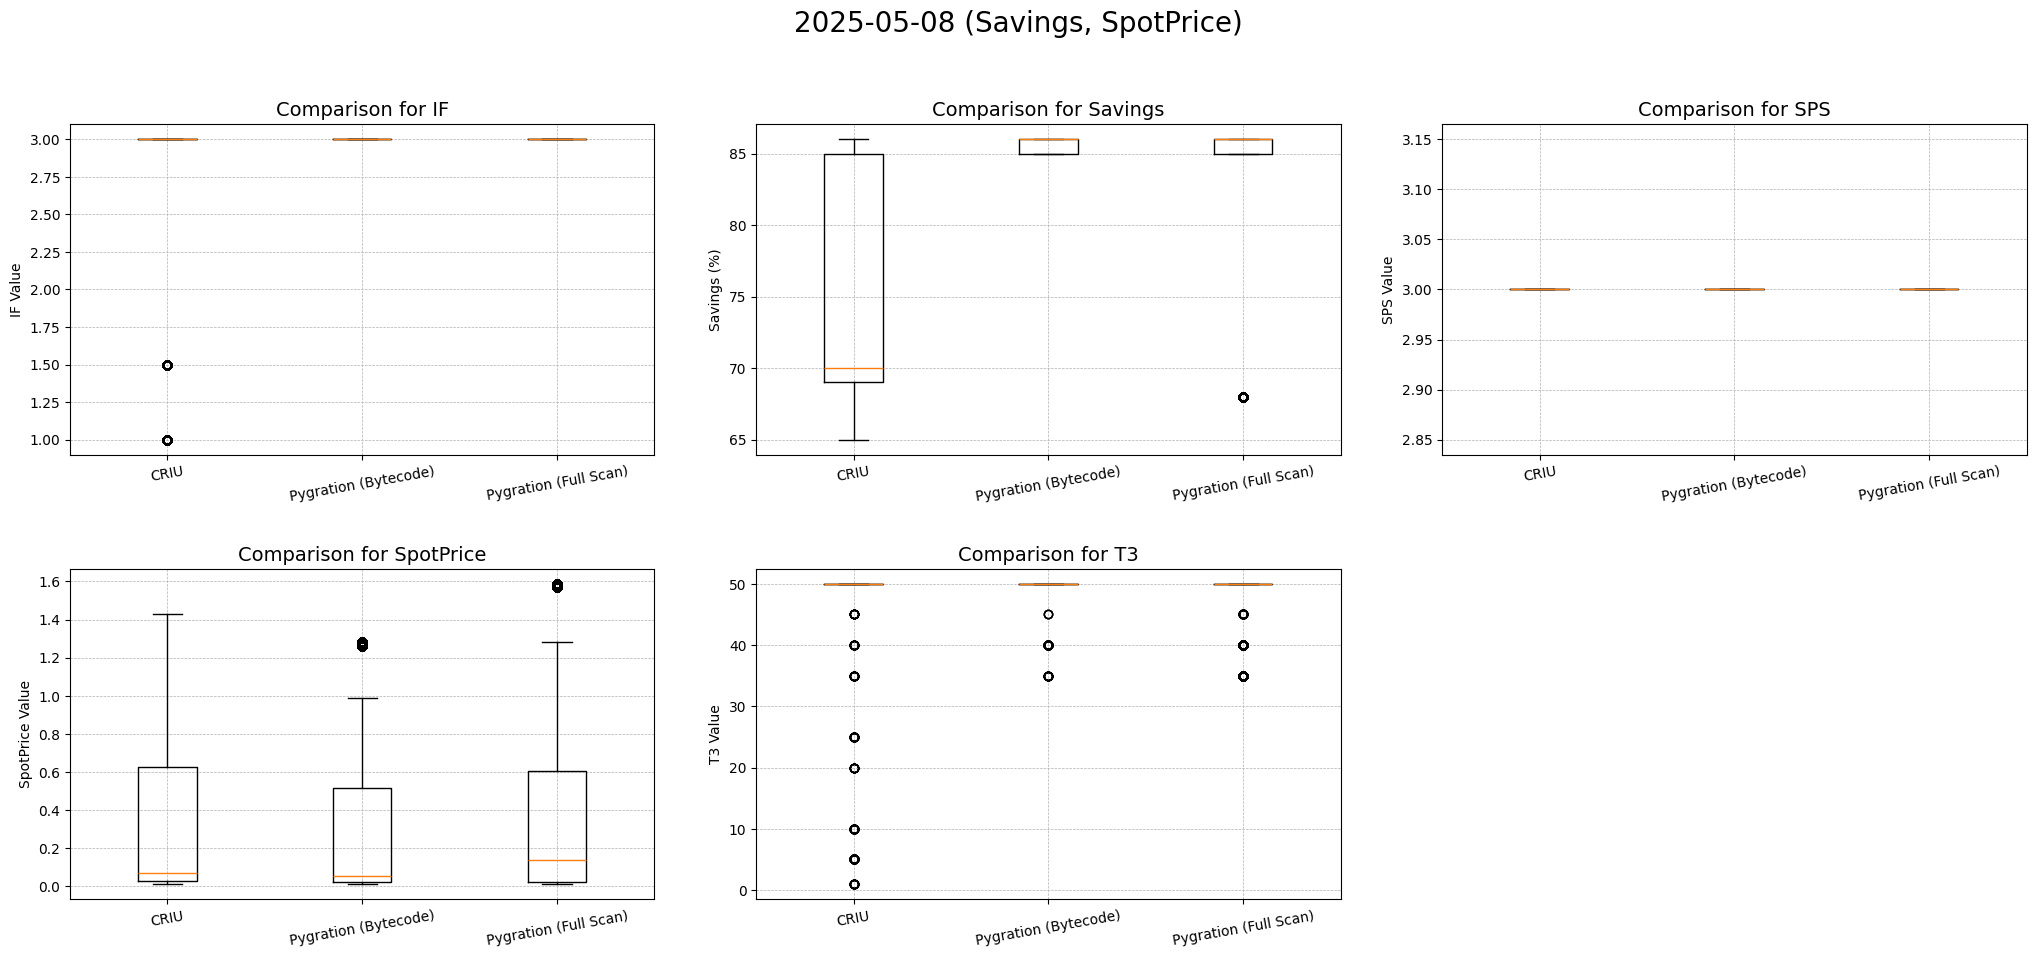

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 전체 지표 개수에 따라 서브플롯의 행과 열 개수를 동적으로 계산합니다.
num_metrics = len(METRICS_TABLE)
# 가로로 긴 형태를 위해 열의 개수는 3으로 고정합니다.
ncols = 3
# 필요한 행의 개수를 계산합니다.
nrows = (num_metrics + ncols - 1) // ncols

# 2. 서브플롯을 포함할 전체 그림(figure)을 생성합니다.
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 7, nrows * 5))
# 다차원 배열일 수 있는 axes를 1차원 배열로 만들어 쉽게 순회할 수 있도록 합니다.
axes = axes.flatten()

# 3. 각 지표에 대해 반복하며 해당하는 서브플롯에 그래프를 그립니다.
for i, metric in enumerate(METRICS_TABLE):
    ax = axes[i]
    
    data_criu = pd.to_numeric(criu_results[metric], errors='coerce')
    data_pygration = pd.to_numeric(pygration_results[metric], errors='coerce')
    data_pygration_full_scan = pd.to_numeric(pygration_full_scan_results[metric], errors='coerce')

    # NaN 값 제거
    data_criu = data_criu[~np.isnan(data_criu)]
    data_pygration = data_pygration[~np.isnan(data_pygration)]
    data_pygration_full_scan = data_pygration_full_scan[~np.isnan(data_pygration_full_scan)]

    # --- 통계 정보 출력 (기존과 동일) ---
    print(f"--- Summary Statistics for {metric} (sorted by SpotPrice ASC) ---")
    summary_df = pd.DataFrame({
        'CRIU': pd.Series(data_criu).describe(),
        'Pygration (Bytecode)': pd.Series(data_pygration).describe(),
        'Pygration (Full Scan)': pd.Series(data_pygration_full_scan).describe()
    })
    print(summary_df)
    print("\n")

    # --- 서브플롯에 그래프 그리기 ---
    plot_data = []
    labels = []
    if len(data_criu) > 0:
        plot_data.append(data_criu)
        labels.append('CRIU')
    if len(data_pygration) > 0:
        plot_data.append(data_pygration)
        labels.append('Pygration (Bytecode)')
    if len(data_pygration_full_scan) > 0:
        plot_data.append(data_pygration_full_scan)
        labels.append('Pygration (Full Scan)')
        
    if not plot_data:
        ax.set_title(f"No data for {metric}")
        ax.set_xticks([])
        ax.set_yticks([])
        continue

    ax.boxplot(plot_data, tick_labels=labels)
    
    title = f'Comparison for {metric}'
    ylabel = f'{metric} Value'
    if metric == 'Savings':
        ylabel = f'{metric} (%)'
        
    ax.set_title(title, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.tick_params(axis='x', labelsize=10, rotation=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# 4. 사용되지 않은 나머지 서브플롯은 보이지 않게 처리합니다.
for j in range(num_metrics, len(axes)):
    fig.delaxes(axes[j])

# 5. 전체 그림의 최상단에 중앙 정렬된 제목(메모)을 추가합니다.
fig.suptitle("2025-05-08 (Savings, SpotPrice)", fontsize=20)

# 6. 그래프들이 겹치지 않도록 레이아웃을 조정한 후, 최종 이미지를 한번에 출력합니다.
plt.tight_layout(pad=3.0)
plt.show()

In [15]:
import json
from decimal import Decimal

# Custom JSON serializer for Decimal objects
def decimal_serializer(obj):
    if isinstance(obj, Decimal):
        return float(obj)
    raise TypeError(f"Object of type {obj.__class__.__name__} is not JSON serializable")

# Consolidate data into a single dictionary
export_data = {
    'criu': criu_results,
    'pygration_bytecode': pygration_results,
    'pygration_full_scan': pygration_full_scan_results
}

# Define the output file path
output_filename = 'plot_data.json'

# Write the data to a JSON file
try:
    with open(output_filename, 'w') as f:
        json.dump(export_data, f, indent=4, default=decimal_serializer)
    print(f"Successfully exported data to {output_filename}")
except Exception as e:
    print(f"Error exporting data to JSON: {e}")


Successfully exported data to plot_data.json


In [31]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

def get_data_for_date(instance_types: list, date: str):
    """
    For a given date, finds the best instance based on the sorting criteria,
    and returns all its metrics from the METRICS_TABLE.
    
    :param instance_types: A list of instance types to consider.
    :param date: A string representing the date in 'YYYY-MM-DD' format.
    """
    if not instance_types:
        return pd.DataFrame()

    # Constructing the columns to select, ensuring proper quoting for all
    selected_columns = ", ".join([f'{METRICS[col]} AS "{col}"' for col in METRICS_TABLE])
    
    start_time = f"{date} 00:00:00"
    end_time = (pd.to_datetime(date) + pd.Timedelta(days=1)).strftime('%Y-%m-%d %H:%M:%S')

    query = f"""
    SELECT Time, {selected_columns}
    FROM data
    WHERE Region = 'us-west-2'
          AND Time >= '{start_time}'
          AND Time < '{end_time}'
          AND InstanceType IN %(instance_types)s
    GROUP BY Time
    ORDER BY Time
    """

    # Use a tuple of instance_types and query for cache key
    it_json = json.dumps(sorted(list(instance_types)))
    cache_key = (it_json, query)

    if cache_key in cache:
        return cache[cache_key]

    try:
        result_df = client.query_df(query, parameters={'instance_types': instance_types})
        cache[cache_key] = result_df
        return result_df
    except Exception as e:
        # print(f"An error occurred during query for date {date}: {e}")
        return pd.DataFrame()

def calculate_metrics_for_date(date):
    criu_results = {metric: [] for metric in METRICS_TABLE}
    pygration_results = {metric: [] for metric in METRICS_TABLE}

    for instance_type, data in migration_data.items():
        if instance_type not in ALL_INSTANCE_SPECS:
            continue
        
        criu_instances = filter_by_specs(data.get('criu', []))
        
        pygration_instance_sets = []
        pygration_workloads = data.get('pygration', {})
        for workload, instances in pygration_workloads.items():
            if "dask_matmul" in workload:
                continue
            pygration_instance_sets.append(filter_by_specs(instances))

        # --- CRIU ---
        if criu_instances:
            criu_df = get_data_for_date(criu_instances, date)
            if not criu_df.empty:
                for metric in METRICS_TABLE:
                    criu_results[metric].extend(criu_df[metric].tolist())

        # --- Pygration (Bytecode) ---
        for instance_set in pygration_instance_sets:
            if not instance_set: continue
            pygration_df = get_data_for_date(instance_set, date)
            if not pygration_df.empty:
                for metric in METRICS_TABLE:
                    pygration_results[metric].extend(pygration_df[metric].tolist())

    return criu_results, pygration_results

def process_date(date):
    date_str = date.strftime('%Y-%m-%d')
    try:
        criu_results, pygration_results = calculate_metrics_for_date(date_str)
        
        criu_means = {metric: pd.Series(data).dropna().mean() for metric, data in criu_results.items() if data}
        pygration_means = {metric: pd.Series(data).dropna().mean() for metric, data in pygration_results.items() if data}

        criu_means = {k: float(v) for k, v in criu_means.items() if pd.notna(v)}
        pygration_means = {k: float(v) for k, v in pygration_means.items() if pd.notna(v)}

        if not criu_means or not pygration_means:
            return date_str, -float('inf')

        score = 0
        higher_is_better = ['IF', 'Savings']
        lower_is_better = []

        for metric in higher_is_better:
            if metric in pygration_means and metric in criu_means and criu_means.get(metric, 0) > 0:
                score += (pygration_means[metric] - criu_means[metric]) / criu_means[metric]

        for metric in lower_is_better:
            if metric in pygration_means and metric in criu_means and criu_means.get(metric, 0) > 0:
                score += (criu_means[metric] - pygration_means[metric]) / criu_means[metric]
                
        return date_str, score
    except Exception as e:
        # print(f"Error processing {date_str}: {e}")
        return date_str, -float('inf')

# Get date range from the database
try:
    range_df = client.query_df("SELECT min(CAST(Time AS Date)), max(CAST(Time AS Date)) FROM data WHERE SpotPrice > 0")
    min_date, max_date = range_df.iloc[0]

    date_range = pd.date_range(min_date, max_date)
    scores_by_date = {}

    with ThreadPoolExecutor(max_workers=36) as executor:
        futures = [executor.submit(process_date, date) for date in date_range]
        
        for future in tqdm(as_completed(futures), total=len(date_range), desc="Processing dates"):
            try:
                date_str, score = future.result()
                if score is not None:
                    scores_by_date[date_str] = score
            except Exception as e:
                # This can be used to debug issues within a future
                # print(f"A future resulted in an exception: {e}")
                pass

    if scores_by_date:
        # Filter out inf scores before finding max
        valid_scores = {d: s for d, s in scores_by_date.items() if s > -float('inf')}
        if valid_scores:
            best_date = max(valid_scores, key=valid_scores.get)
            max_score = valid_scores[best_date]
            print(f"\\nBest date found: {best_date} with a score of {max_score:.4f}")
        else:
            print("\\nNo dates with valid scores found.")
    else:
        print("\\nCould not find a suitable date in the given range.")
        
except Exception as e:
    print(f"An error occurred: {e}")


Processing dates:   0%|          | 0/578 [00:00<?, ?it/s]

\nBest date found: 2025-05-08 with a score of 0.2423


In [ ]:
try:
    # 1. migration_data를 기반으로 SQL의 WITH 절 동적 생성
    union_all_statements = []
    
    for source_instance, data in migration_data.items():
        if source_instance not in ALL_INSTANCE_SPECS:
            continue
        
        # CRIU 인스턴스 처리
        criu_instances = filter_by_specs(data.get('criu', []))
        for target_instance in criu_instances:
            union_all_statements.append(f"SELECT '{source_instance}' AS source_instance, 'criu' AS method, '{target_instance}' AS target_instance")
            
        # Pygration 인스턴스 처리
        pygration_workloads = data.get('pygration', {})
        pygration_instances = set()
        for workload, instances in pygration_workloads.items():
            if "dask_matmul" in workload:
                continue
            for inst in filter_by_specs(instances):
                pygration_instances.add(inst)
        
        for target_instance in pygration_instances:
            union_all_statements.append(f"SELECT '{source_instance}' AS source_instance, 'pygration' AS method, '{target_instance}' AS target_instance")

    migration_map_sql = "\\nUNION ALL ".join(union_all_statements)

    # 2. 전체 SQL 쿼리 템플릿에 동적으로 생성된 WITH 절 삽입
    final_query = f"""
    WITH
        migration_map AS (
            {migration_map_sql}
        ),
        instance_sets AS (
            SELECT
                arrayDistinct(groupArray(target_instance)) AS all_targets
            FROM migration_map
        ),
        daily_metrics AS (
            SELECT
                CAST(Time AS Date) AS Day,
                InstanceType,
                minIf(SpotPrice, SpotPrice >= 0) AS SpotPrice,
                max("IF") AS "IF",
                max("Savings") AS "Savings",
                max("SPS") AS "SPS",
                max("T3") AS "T3"
            FROM data
            WHERE
                Region = 'us-west-2'
                AND SpotPrice > 0
                AND InstanceType IN (SELECT arrayJoin(all_targets) FROM instance_sets)
            GROUP BY
                Day,
                InstanceType
        ),
        final_daily_comparison AS (
            SELECT
                Day,
                minIf(dm.SpotPrice, mm.method = 'criu') AS criu_SpotPrice,
                maxIf(dm."IF", mm.method = 'criu') AS criu_IF,
                maxIf(dm."Savings", mm.method = 'criu') AS criu_Savings,
                maxIf(dm."SPS", mm.method = 'criu') AS criu_SPS,
                maxIf(dm."T3", mm.method = 'criu') AS criu_T3,
                minIf(dm.SpotPrice, mm.method = 'pygration') AS pygration_SpotPrice,
                maxIf(dm."IF", mm.method = 'pygration') AS pygration_IF,
                maxIf(dm."Savings", mm.method = 'pygration') AS pygration_Savings,
                maxIf(dm."SPS", mm.method = 'pygration') AS pygration_SPS,
                maxIf(dm."T3", mm.method = 'pygration') AS pygration_T3
            FROM daily_metrics dm
            JOIN migration_map mm ON dm.InstanceType = mm.target_instance
            GROUP BY Day
        )
    SELECT
        Day,
        (
            (pygration_IF - criu_IF) / criu_IF +
            (pygration_Savings - criu_Savings) / criu_Savings +
            (pygration_SPS - criu_SPS) / criu_SPS +
            (pygration_T3 - criu_T3) / criu_T3 +
            (criu_SpotPrice - pygration_SpotPrice) / criu_SpotPrice
        ) AS score
    FROM final_daily_comparison
    WHERE
        criu_SpotPrice > 0 AND pygration_SpotPrice > 0 AND
        criu_IF > 0 AND pygration_IF > 0 AND
        criu_Savings > 0 AND pygration_Savings > 0 AND
        criu_SPS > 0 AND pygration_SPS > 0 AND
        criu_T3 > 0 AND pygration_T3 > 0
    ORDER BY score DESC
    LIMIT 10
    """

    # print("--- Generated SQL Query ---")
    # print(final_query)
    
    # 3. 쿼리 실행 및 결과 출력
    print("\\nExecuting query on ClickHouse...")
    result_df = client.query_df(final_query)

    if not result_df.empty:
        print("\\n--- Top 10 Best Dates for Pygration ---")
        print(result_df)
    else:
        print("\\nNo suitable date found.")

except Exception as e:
    print(f"An error occurred: {e}")



In [36]:
import os
import pandas as pd
import numpy as np

src_instance = 't3.medium'

print(f"--- CPU Feature Analysis for Pygration on {src_instance} ---")

# Get source instance's total supported ISA sets
src_supported_isa_sets = set()
if src_instance in ISASET_CACHE:
    src_supported_isa_sets = ISASET_CACHE[src_instance]
else:
    src_isaset_path = os.path.join(CPUINFO_ALL_DIR, src_instance, "isaset.csv")
    if os.path.exists(src_isaset_path):
        try:
            df_src_isaset = pd.read_csv(src_isaset_path)
            src_supported_isa_sets = set(df_src_isaset.columns[df_src_isaset.iloc[0] == 1])
            ISASET_CACHE[src_instance] = src_supported_isa_sets
        except Exception as e:
            print(f"Error processing ISA set file for {src_instance}: {e}")
    else:
        print(f"ISA set file not found for {src_instance}")

total_features = len(src_supported_isa_sets)
if total_features > 0:
    print(f"Total supported features on {src_instance}: {total_features}")
    print("-" * 20)

    src_collect_path = os.path.join(COLLECT_INFO_DIR, src_instance)
    if os.path.isdir(src_collect_path):
        files = os.listdir(src_collect_path)
        
        workloads_data = {}

        # Bytecode analysis
        workloads_bytecode = sorted([f for f in files if f.endswith(".bytecode.csv")])
        for workload_file in workloads_bytecode:
            workload_name = workload_file.replace(".bytecode.csv", "")
            if workload_name not in workloads_data:
                workloads_data[workload_name] = {}
            
            bytecode_path = os.path.join(src_collect_path, workload_file)
            try:
                df_bytecode = pd.read_csv(bytecode_path)
                required_isa_sets = set(df_bytecode[df_bytecode['ISA_SET'] != 'Error']['ISA_SET'].unique())
                normalized_isa_sets = required_isa_sets.intersection(src_supported_isa_sets)
                
                count = len(normalized_isa_sets)
                ratio = count / total_features if total_features > 0 else 0
                workloads_data[workload_name]['bytecode'] = (count, ratio)
            except Exception as e:
                workloads_data[workload_name]['bytecode'] = ('Error', 'Error')

        # Full scan analysis
        workloads_full_scan = sorted([f for f in files if f.endswith(".text_segment_full_scan.csv")])
        for workload_file in workloads_full_scan:
            workload_name = workload_file.replace(".text_segment_full_scan.csv", "")
            if workload_name not in workloads_data:
                workloads_data[workload_name] = {}
            
            full_scan_path = os.path.join(src_collect_path, workload_file)
            try:
                df_full_scan = pd.read_csv(full_scan_path)
                required_isa_sets = set(df_full_scan[df_full_scan['ISA_SET'] != 'Error']['ISA_SET'].unique())
                normalized_isa_sets = required_isa_sets.intersection(src_supported_isa_sets)

                count = len(normalized_isa_sets)
                ratio = count / total_features if total_features > 0 else 0
                workloads_data[workload_name]['full_scan'] = (count, ratio)
            except Exception as e:
                workloads_data[workload_name]['full_scan'] = ('Error', 'Error')

        # Print results per workload
        for workload, data in sorted(workloads_data.items()):
            print(f"Workload: {workload}")
            if 'bytecode' in data:
                count, ratio = data['bytecode']
                if isinstance(count, int):
                    print(f"  Pygration (bytecode): {count} features ({ratio:.2%})")
                else:
                    print(f"  Pygration (bytecode): Error processing data.")
            
            if 'full_scan' in data:
                count, ratio = data['full_scan']
                if isinstance(count, int):
                    print(f"  Pygration (full scan): {count} features ({ratio:.2%})")
                else:
                    print(f"  Pygration (full scan): Error processing data.")
            print()
    else:
        print(f"Collection directory not found for {src_instance}")
else:
    print(f"Could not retrieve total supported features for {src_instance}. Cannot proceed with analysis.")



--- CPU Feature Analysis for Pygration on t3.medium ---
Total supported features on t3.medium: 107
--------------------
Workload: beautifulsoup4
  Pygration (bytecode): 28 features (26.17%)
  Pygration (full scan): 39 features (36.45%)

Workload: dask_matmul
  Pygration (bytecode): 29 features (27.10%)
  Pygration (full scan): 61 features (57.01%)

Workload: dask_uuid
  Pygration (bytecode): 28 features (26.17%)
  Pygration (full scan): 54 features (50.47%)

Workload: falcon_http
  Pygration (bytecode): 28 features (26.17%)
  Pygration (full scan): 54 features (50.47%)

Workload: fastapi
  Pygration (bytecode): 28 features (26.17%)
  Pygration (full scan): 54 features (50.47%)

Workload: int8dot
  Pygration (bytecode): 31 features (28.97%)
  Pygration (full scan): 39 features (36.45%)

Workload: llm
  Pygration (bytecode): 28 features (26.17%)
  Pygration (full scan): 62 features (57.94%)

Workload: matmul
  Pygration (bytecode): 30 features (28.04%)
  Pygration (full scan): 51 feature